In [33]:
# coding=utf-8
import math
from scapy.all import *
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from scipy.stats import t
from math import sqrt
from math import pow

hosts = dict([('www.uq.edu.au','130.102.131.70'),('sydney.edu.au','129.78.5.8')])

DEFAULT_RTT_VALUE = 0

ATTEMPS = 30

In [34]:
def modified_thompson(n):
    alpha = 0.025
    t_critical = t.ppf(1-alpha, n-2)
    return (t_critical*(n-1)) / (sqrt(n) * sqrt(n-2 + pow(t_critical,2)))  

In [35]:
def enviar_paquete(host, time_to_live):
    packet = IP(dst=host, ttl=time_to_live) / ICMP()
    res = sr(packet, timeout=1, verbose=0)
    return res[0][ICMP]

In [36]:
def route(df):
    return df[df['ip'] != 'empty']['ip'].unique()

In [37]:
def trace_route(hosts):
    
    hops = []

    for host in hosts:
        ttl_without_response = []
        ip = hosts[host]
        for i in range(0,ATTEMPS):
            tipo = 11
            ttl = 1
            last_rtt = 0
            while (tipo!=0 and ttl < 30):
                if (not ttl in ttl_without_response):
                    ti = time.time()
                    res1 = enviar_paquete(ip, ttl)
                    tf = time.time()
                    rtt = tf-ti
                    if (len(res1) > 0):
                        tipo = res1[0][1].type
                        src = res1[0][1].src
                        if (tipo > 0):
                            hops.append([host,ttl,i,src,max(0,rtt-last_rtt)])
                        else:
                            hops.append([host,ttl,i,src,rtt-last_rtt])
                        last_rtt = rtt
                    else:
                        hops.append([host,ttl,i,"empty",DEFAULT_RTT_VALUE])
                        ttl_without_response.append(ttl)
                ttl = ttl + 1

    hops_info = pd.DataFrame(hops,columns=['host','ttl','i','ip','rtt'])
    return hops_info

In [27]:
df = trace_route(hosts)

In [44]:
df_indexed = df.set_index(['host','ttl','i','ip'])
rtt = df_indexed.groupby(level=['host','ttl','ip']).mean()
descriptions = rtt.describe().T
mean = descriptions['mean']
std = descriptions['std']
zrtt = abs(rtt-mean)/std
n = len(zrtt)
thomson_value = modified_thompson(n)
rtt
outliers = zrtt[zrtt['rtt'] > thomson_value]
from IPython.display import Latex
Latex(outliers.to_latex())

<IPython.core.display.Latex object>

In [30]:
routeRespose = route(df)
routeRespose

array(['200.89.161.81', '200.89.165.1', '200.89.165.250', '67.17.94.249',
       '4.68.127.54', '129.250.4.250', '129.250.2.219', '129.250.7.69',
       '129.250.3.123', '204.1.253.166', '202.158.194.172',
       '113.197.15.68', '113.197.15.66', '113.197.15.152', '113.197.15.4',
       '113.197.15.7', '113.197.15.34', '138.44.129.46', '130.102.159.1',
       '130.102.0.242', '130.102.82.63', '130.102.131.70'], dtype=object)

In [31]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
from __future__ import print_function, unicode_literals, with_statement
import argparse
import contextlib
import requests
import sys
import csv
import matplotlib
# Anti-Grain Geometry (AGG) backend so PyGeoIpMap can be used 'headless'
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pygeoip


def get_ip(ip_file):
    """
    Returns a list of IP addresses from a file containing one IP per line.
    """
    with contextlib.closing(ip_file):
        return [line.strip() for line in ip_file]


def get_lat_lon(ip_list=[], lats=[], lons=[]):
    """
    This function connects to the FreeGeoIP web service to get info from
    a list of IP addresses.
    Returns two lists (latitude and longitude).
    """
    print("Processing {} IPs...".format(len(ip_list)))
    for ip in ip_list:
        r = requests.get("https://freegeoip.net/json/" + ip)
        json_response = r.json()
        print("{ip}, {region_name}, {country_name}, {latitude}, {longitude}".format(**json_response))
        if json_response['latitude'] and json_response['longitude']:
            lats.append(json_response['latitude'])
            lons.append(json_response['longitude'])
    return lats, lons


def geoip_lat_lon(gi, ip_list=[], lats=[], lons=[]):
    """
    This function uses the MaxMind library and databases to geolocate IP addresses
    Returns two lists (latitude and longitude).
    """
    print("Processing {} IPs...".format(len(ip_list)))
    for ip in ip_list:
        try:
            r = gi.record_by_addr(ip)
        except Exception:
            print("Unable to locate IP: %s" % ip)
            continue
        if r is not None:
            print("%s {country_code} {latitude}, {longitude}".format(**r) % ip)
            lats.append(r['latitude'])
            lons.append(r['longitude'])
    return lats, lons


def get_lat_lon_from_csv(csv_file, lats=[], lons=[]):
    """
    Retrieves the last two rows of a CSV formatted file to use as latitude
    and longitude.
    Returns two lists (latitudes and longitudes).
    Example CSV file:
    119.80.39.54, Beijing, China, 39.9289, 116.3883
    101.44.1.135, Shanghai, China, 31.0456, 121.3997
    219.144.17.74, Xian, China, 34.2583, 108.9286
    64.27.26.7, Los Angeles, United States, 34.053, -118.2642
    """
    with contextlib.closing(csv_file):
        reader = csv.reader(csv_file)
        for row in reader:
            lats.append(row[-2])
            lons.append(row[-1])

    return lats, lons


def generate_map(output, lats=[], lons=[], wesn=None):
    """
    Using Basemap and the matplotlib toolkit, this function generates a map and
    puts a red dot at the location of every IP addresses found in the list.
    The map is then saved in the file specified in `output`.
    """
    
    plt.clf()
    print("Generating map and saving it to {}".format(output))
    if wesn:
        wesn = [float(i) for i in wesn.split('/')]
        m = Basemap(projection='cyl', resolution='l',
                llcrnrlon=wesn[0], llcrnrlat=wesn[2],
                urcrnrlon=wesn[1], urcrnrlat=wesn[3])
    else:
        m = Basemap(projection='cyl', resolution='l')
    m.bluemarble()

    x, y = m(lons, lats)
    
    m.plot(x, y, 40, 40, color='y')
    m.scatter(x, y, s=3, color='#ff0000', marker='o', alpha=0.3) #, alpha=0.3
    
    plt.figure(figsize=(10,6), dpi=80)
    
    plt.show()

    plt.savefig(output, dpi=300, bbox_inches='tight')

def graficar_ruta(ruta, nombre_imagen):
    gi = pygeoip.GeoIP('GeoLiteCity.dat')
    lats, lons = geoip_lat_lon(gi, ruta)
    generate_map(nombre_imagen, lats, lons) #, wesn='-12/45/30/65'

Processing 22 IPs...
200.89.161.81 AR -34.6006, -58.4887
200.89.165.1 AR -34.6006, -58.4887
200.89.165.250 AR -34.6006, -58.4887
67.17.94.249 US 37.751, -97.822
4.68.127.54 US 37.751, -97.822
129.250.4.250 US 39.6237, -104.8738
129.250.2.219 US 39.6237, -104.8738
129.250.7.69 US 39.6237, -104.8738
129.250.3.123 US 39.6237, -104.8738
204.1.253.166 US 39.6237, -104.8738
202.158.194.172 AU -31.9522, 115.8614
113.197.15.68 AU -35.276, 149.1344
113.197.15.66 AU -35.276, 149.1344
113.197.15.152 AU -35.276, 149.1344
113.197.15.4 AU -35.276, 149.1344
113.197.15.7 AU -35.276, 149.1344
113.197.15.34 AU -35.276, 149.1344
138.44.129.46 AU -28.8133, 153.2758
130.102.159.1 AU -27.4982, 153.0004
130.102.0.242 AU -33.494, 143.2104
130.102.82.63 AU -27.4982, 153.0004
130.102.131.70 AU -27.4982, 153.0004
Generating map and saving it to salida.png


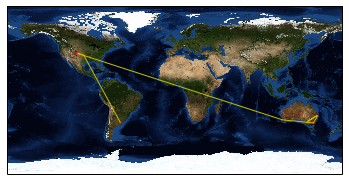

AssertionError: 

In [32]:
graficar_ruta(routeRespose, 'salida.png')